<a href="https://colab.research.google.com/github/chien2734/sgu_data_analyst/blob/chien/Lab03_BuiDucChien_3122410039.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

# Phân loại nguy cơ Tiểu đường — Pima Indians


## 1. Định nghĩa vấn đề (Define Problem)
+ **Mô tả:**
  + Dùng bộ dữ liệu Pima Indians để dự đoán xem một phụ nữ Pima (≥21 tuổi) có **mắc tiểu đường trong 5 năm** (Outcome = 1) hay không (Outcome = 0)
  + Bộ dữ liệu gồm 768 mẫu
+ Dữ liệu vào:
  + Pregnancies: số lần mang thai
  + Glucose: nồng độ glucose huyết tương sau 2 giờ (OGTT) (mg/dL)
  + BloodPressure: huyết áp tâm trương (mm Hg)
  + SkinThickness: độ dày nếp gấp da (mm)
  + Insulin: nồng độ insulin sau 2 giờ (μU/ml)
  + BMI: body mass index (kg/m²)
  + DiabetesPedigreeFunction (DPF): chỉ số phả hệ tiểu đường
  + Age: tuổi (năm)
+ Kết quả:
  + Outcome: 0 = không mắc bệnh trong 5 năm
  + Outcome: 1 = mắc bệnh trong 5 năm

## 2. Chuẩn bị vấn đề (Prepare Problem)

### 2.1. Khai báo thư viện (Load Libraries)

In [2]:
import os, sys
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
import seaborn as sns

from sklearn.model_selection import train_test_split, StratifiedKFold, cross_val_score
from sklearn.preprocessing import StandardScaler
from sklearn.impute import SimpleImputer
from sklearn.linear_model import LogisticRegression
from sklearn.ensemble import RandomForestClassifier
from sklearn.metrics import (
    accuracy_score, precision_score, recall_score, f1_score,
    confusion_matrix, roc_auc_score, roc_curve
)

### 2.2. Nạp dữ liệu (Load Dataset)

In [4]:
# Load dataset
data_path = 'pima-indians-diabetes.csv'
data_names = ['Pregnancies', 'Glucose', 'BloodPressure', 'SkinThickness', 'Insulin', 'BMI', 'DPF', 'Age', 'Outcome']
df_dataset = pd.read_csv(data_path, names = data_names)

## 3. Phân tích dữ liệu (Analyze Data)


### 3.1. Thống kê mô tả (Descriptive Statistics)

#### (1) **Hiển thị một số thông tin về dữ liệu**
+ Số dòng, số cột của dữ liệu
+ Kiểu dữ liệu của từng cột
+ 5 dòng đầu và 5 dòng cuối của bảng dữ liệu
+ Thông tin chung về dữ liệu

In [ ]:
# shape
print(f'+ Shape: {df_dataset.shape}')
# types
print(f'+ Data Types: \n{df_dataset.dtypes}')
# head, tail
print(f'+ Contents: ')
print(df_dataset.head(5))
print(df_dataset.tail(5))
# info
df_dataset.info()

+ Shape: (768, 9)
+ Data Types: 
Pregnancies        int64
Glucose            int64
BloodPressure      int64
SkinThickness      int64
Insulin            int64
BMI              float64
DPF              float64
Age                int64
Outcome            int64
dtype: object
+ Contents: 
   Pregnancies  Glucose  BloodPressure  SkinThickness  Insulin   BMI    DPF  \
0            6      148             72             35        0  33.6  0.627   
1            1       85             66             29        0  26.6  0.351   
2            8      183             64              0        0  23.3  0.672   
3            1       89             66             23       94  28.1  0.167   
4            0      137             40             35      168  43.1  2.288   

   Age  Outcome  
0   50        1  
1   31        0  
2   32        1  
3   21        0  
4   33        1  
     Pregnancies  Glucose  BloodPressure  SkinThickness  Insulin   BMI    DPF  \
763           10      101             76           

**Nhận xét:**
  + Tổng số dòng dữ liệu là 768 dòng
  + Giá trị của 8 tính chất được tính với các đơn vị đo khác nhau
  + Tính chất để phân lớp là biến Outcome với 2 giá trị 0 (không mắc bệnh) và 1 (có mắc bệnh)

#### (2) **Kiểm tra tính toàn vẹn của dữ liệu**
+ Dữ liệu có bị trùng lặp không? Hiển thị dòng bị vi phạm.
+ Dữ liệu có tồn tại giá trị Null, NaN không? Hiển thị dòng bị vi phạm.
+ Đặc biệt: các giá trị bằng 0 ở Glucose, BloodPressure, SkinThickness, Insulin, BMI cần thay bằng NaN (vì sinh học không thể bằng 0).

In [5]:
has_null = df_dataset.isnull().sum().any()
has_nan  = df_dataset.isna().sum().any()
n_duplicated = df_dataset.duplicated().sum()

print(f'Tính toàn vẹn dữ liệu:')
print(f'+ Có giá trị Null: {has_null}')
if has_null:
    print(df_dataset[df_dataset.isnull().any(axis=1)])
print(f'+ Có giá trị Nan: {has_nan}')
if has_nan:
    print(df_dataset[df_dataset.isna().any(axis=1)])
print(f'+ Số dòng trùng: {n_duplicated}')

# Kiểm tra số lượng giá trị 0 ở các cột mà 0 là vô lý
print('Số lượng các giá trị 0 ở các cột:')
cols_zero_invalid = ['Glucose','BloodPressure','SkinThickness','Insulin','BMI']
print((df_dataset[cols_zero_invalid] == 0).sum())

Tính toàn vẹn dữ liệu:
+ Có giá trị Null: False
+ Có giá trị Nan: False
+ Số dòng trùng: 0
Số lượng các giá trị 0 ở các cột:
Glucose            5
BloodPressure     35
SkinThickness    227
Insulin          374
BMI               11
dtype: int64


**Nhận xét:**
+ Dữ liệu không có giá trị rỗng (Null, NaN)
+ Dữ liệu không bị trùng lặp

#### (3) **Các tính chất thống kê trên dữ liệu số**
+ Count, Mean, Standard Deviation, Minimum Value
+ 25th Percentile, 50th Percentile (Median), 75th Percentile, Maximum Value

In [ ]:
description = df_dataset.describe().T
print(description)

               count        mean         std     min       25%       50%  \
Pregnancies    768.0    3.845052    3.369578   0.000   1.00000    3.0000   
Glucose        768.0  120.894531   31.972618   0.000  99.00000  117.0000   
BloodPressure  768.0   69.105469   19.355807   0.000  62.00000   72.0000   
SkinThickness  768.0   20.536458   15.952218   0.000   0.00000   23.0000   
Insulin        768.0   79.799479  115.244002   0.000   0.00000   30.5000   
BMI            768.0   31.992578    7.884160   0.000  27.30000   32.0000   
DPF            768.0    0.471876    0.331329   0.078   0.24375    0.3725   
Age            768.0   33.240885   11.760232  21.000  24.00000   29.0000   
Outcome        768.0    0.348958    0.476951   0.000   0.00000    0.0000   

                     75%     max  
Pregnancies      6.00000   17.00  
Glucose        140.25000  199.00  
BloodPressure   80.00000  122.00  
SkinThickness   32.00000   99.00  
Insulin        127.25000  846.00  
BMI             36.60000   67

**Nhận xét:**
  + Glucose > 0 (thường 50–250 mg/dl).
  + BloodPressure 40–200 mmHg.
  + BMI > 10 và < 70 (BMI cực lớn là hiếm).
  + Age > 20 và < 100.
  + Outcome chỉ có 0 hoặc 1.

#### (4) **Tần số xuất hiện (Distribution) trên dữ liệu phân lớp (Class) và dữ liệu danh mục (Category)**

Đối với bài toán phân lớp (classification problem), chúng ta cần tính số lần xuất hiện của thuộc tính phân lớp. Điều này là cần thiết cho vấn đề mất cân bằng (highly imbalanced problems) giữa các lớp nhằm cần xử lý đặc biệt trong bước chuẩn bị dữ liệu.

In [ ]:
df_dataset["Outcome"].value_counts()

,count
Outcome,
0,500
1,268


**Nhận xét:**
  + Dữ liệu cần phân loại là người mắc bệnh **(1)** và người không mắc bệnh **(0)**
  +  Tỉ lệ chênh lệch giữa người không mắc bệnh/ người mắc bệnh là: **500/268**  

#### (5) **Mối tương quan giữa các tính chất (Correlations)**

Sự tương quan (correlation) đề cập đến mối quan hệ giữa hai biến và cách chúng có thể có hoặc không cùng nhau thay đổi.

Phương pháp phổ biến nhất để tính toán tương quan là Pearson's Correlation Coeficient, giả định có một phân phối chuẩn của các thuộc tính liên quan. Tương quan -1 hoặc 1 cho thấy mối tương quan âm hoặc dương đầy đủ tương ứng. Trong khi giá trị 0 hiển thị không tương quan ở tất cả.

$$
r = \frac{\sum_{i=1}^n{\left(x_i - \hat{x}\right)\left(y_i - \hat{y}\right)}}{\sqrt{\sum_{i=1}^n{\left(x_i - \hat{x}\right)^2}\sum_{i=1}^n{\left(y_i - \hat{y}\right)^2}}}
$$

Một số thuật toán học máy như hồi quy tuyến tính và logistic có hiệu suất kém nếu có các thuộc tính tương quan cao trong tập dữ liệu của bạn.

Như vậy, thật sự cần thiết để xem xét tất cả các mối tương quan theo cặp của các thuộc tính trong tập dữ liệu.

In [7]:
corr = df_dataset.corr()
print(corr)


               Pregnancies   Glucose  BloodPressure  SkinThickness   Insulin  \
Pregnancies       1.000000  0.129459       0.141282      -0.081672 -0.073535   
Glucose           0.129459  1.000000       0.152590       0.057328  0.331357   
BloodPressure     0.141282  0.152590       1.000000       0.207371  0.088933   
SkinThickness    -0.081672  0.057328       0.207371       1.000000  0.436783   
Insulin          -0.073535  0.331357       0.088933       0.436783  1.000000   
BMI               0.017683  0.221071       0.281805       0.392573  0.197859   
DPF              -0.033523  0.137337       0.041265       0.183928  0.185071   
Age               0.544341  0.263514       0.239528      -0.113970 -0.042163   
Outcome           0.221898  0.466581       0.065068       0.074752  0.130548   

                    BMI       DPF       Age   Outcome  
Pregnancies    0.017683 -0.033523  0.544341  0.221898  
Glucose        0.221071  0.137337  0.263514  0.466581  
BloodPressure  0.281805  0.0412

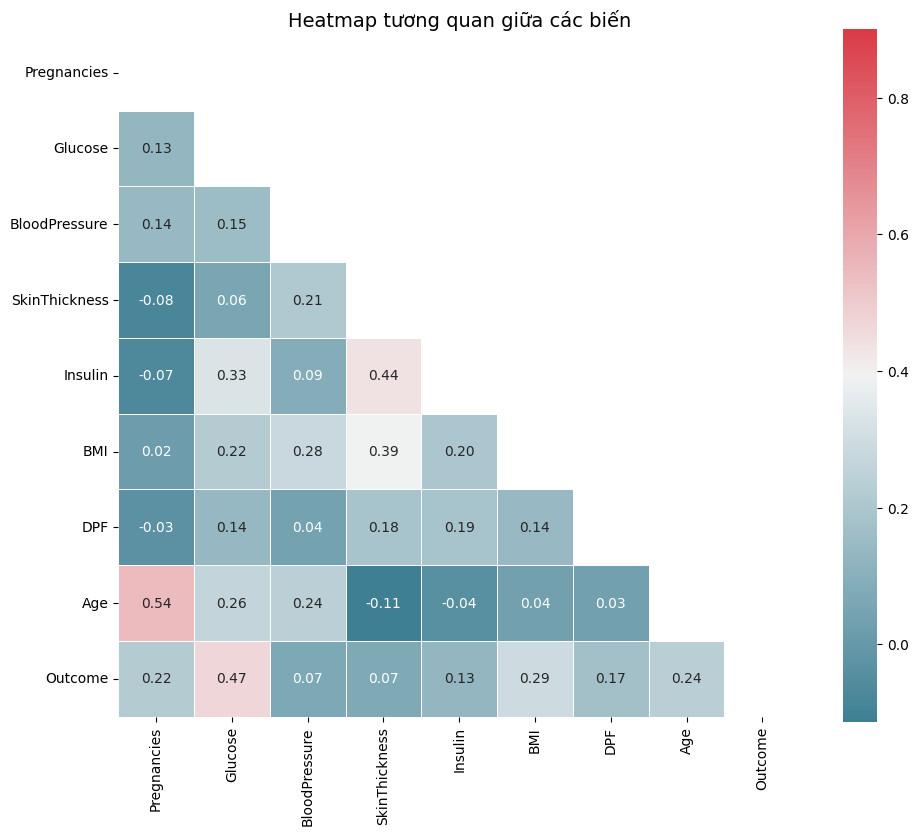

<Figure size 640x480 with 0 Axes>

In [9]:
# Tạo mask cho tam giác trên (để không lặp lại giá trị)
mask = np.zeros_like(corr, dtype=bool)
mask[np.triu_indices_from(mask)] = True

# Tạo figure
f, ax = plt.subplots(figsize=(11, 9))

# Tạo colormap
cmap = sns.diverging_palette(220, 10, as_cmap=True)

# Vẽ heatmap
sns.heatmap(corr, mask=mask, cmap=cmap, vmax=.9, square=True,
            linewidths=.5, annot=True, fmt=".2f", ax=ax)

plt.title("Heatmap tương quan giữa các biến", fontsize=14)
plt.show()
plt.savefig('heatmap.png')

**Nhận xét ma trận tương quan:**

  + **Glucose** (0.47) có tương quan mạnh nhất với Outcome → yếu tố dự báo chính.

  + **BMI** (0.29), **Age** (0.24), **Pregnancies** (0.22) cũng có liên hệ đáng kể → yếu tố nguy cơ quan trọng.

  + **DPF** (0.17), **Insulin** (0.13), **SkinThickness** (0.07), **BloodPressure** (0.06) tương quan yếu → chỉ mang tính bổ trợ.

+ Quan hệ giữa predictors: **Age–Pregnancies** (0.54), **SkinThickness–Insulin** (0.44), **SkinThickness–BMI** (0.39), **Glucose–Insulin** (0.33) → đều hợp lý về sinh học.

+ Không có đa cộng tuyến nghiêm trọng (tương quan giữa predictors < 0.8).

### 3.2. Hiển thị dữ liệu (Visualize Data)

#### (1) Hiển thị trên từng tính chất đơn (Univariate Plots)
**Box and whisker plots**

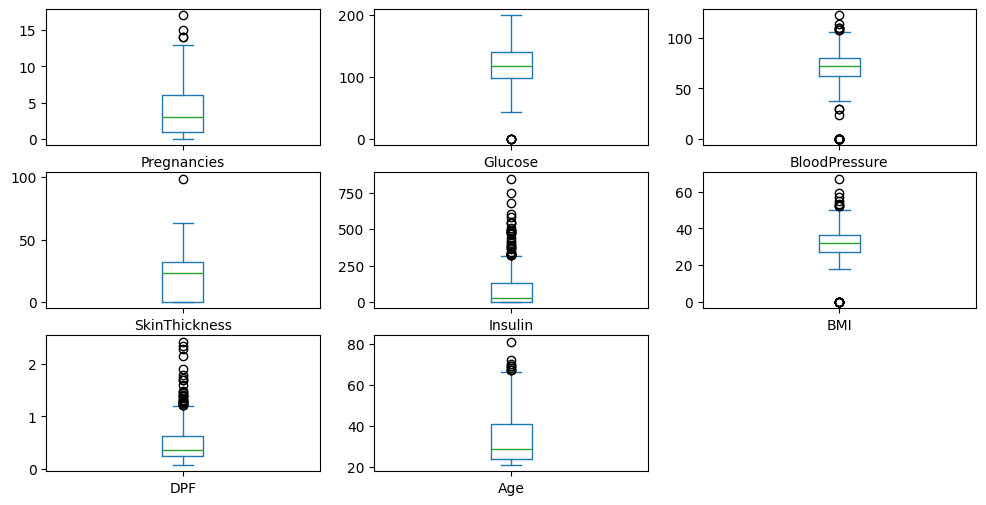

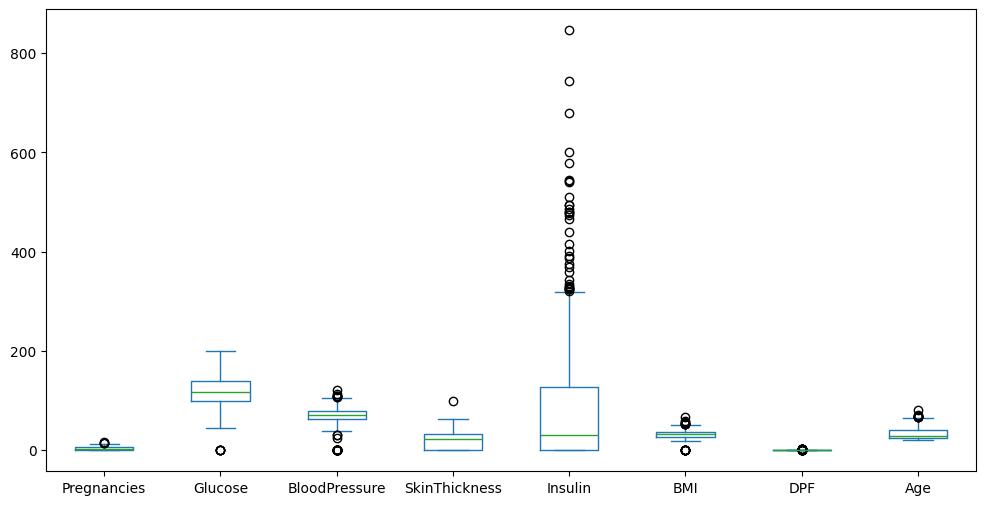

In [28]:
cols = df_dataset.columns[:-1]  # bỏ cột Outcome
df_dataset[cols].plot(kind="box", subplots=True, layout=(3, 3), sharex=False, sharey=False, figsize=(12,6));
df_dataset[cols].plot(kind="box", figsize=(12,6));

**Biểu đồ Histogram**

  Chúng ta có thể quan sát kỹ hơn mối quan hệ giữa Outcome và các biến dự đoán bằng cách sử dụng biểu đồ histogram như dưới đây. Ở mỗi biểu đồ, phần thứ nhất biểu diễn nhóm Outcome = 0 (không mắc tiểu đường), còn phần thứ hai biểu diễn nhóm Outcome = 1 (mắc tiểu đường).

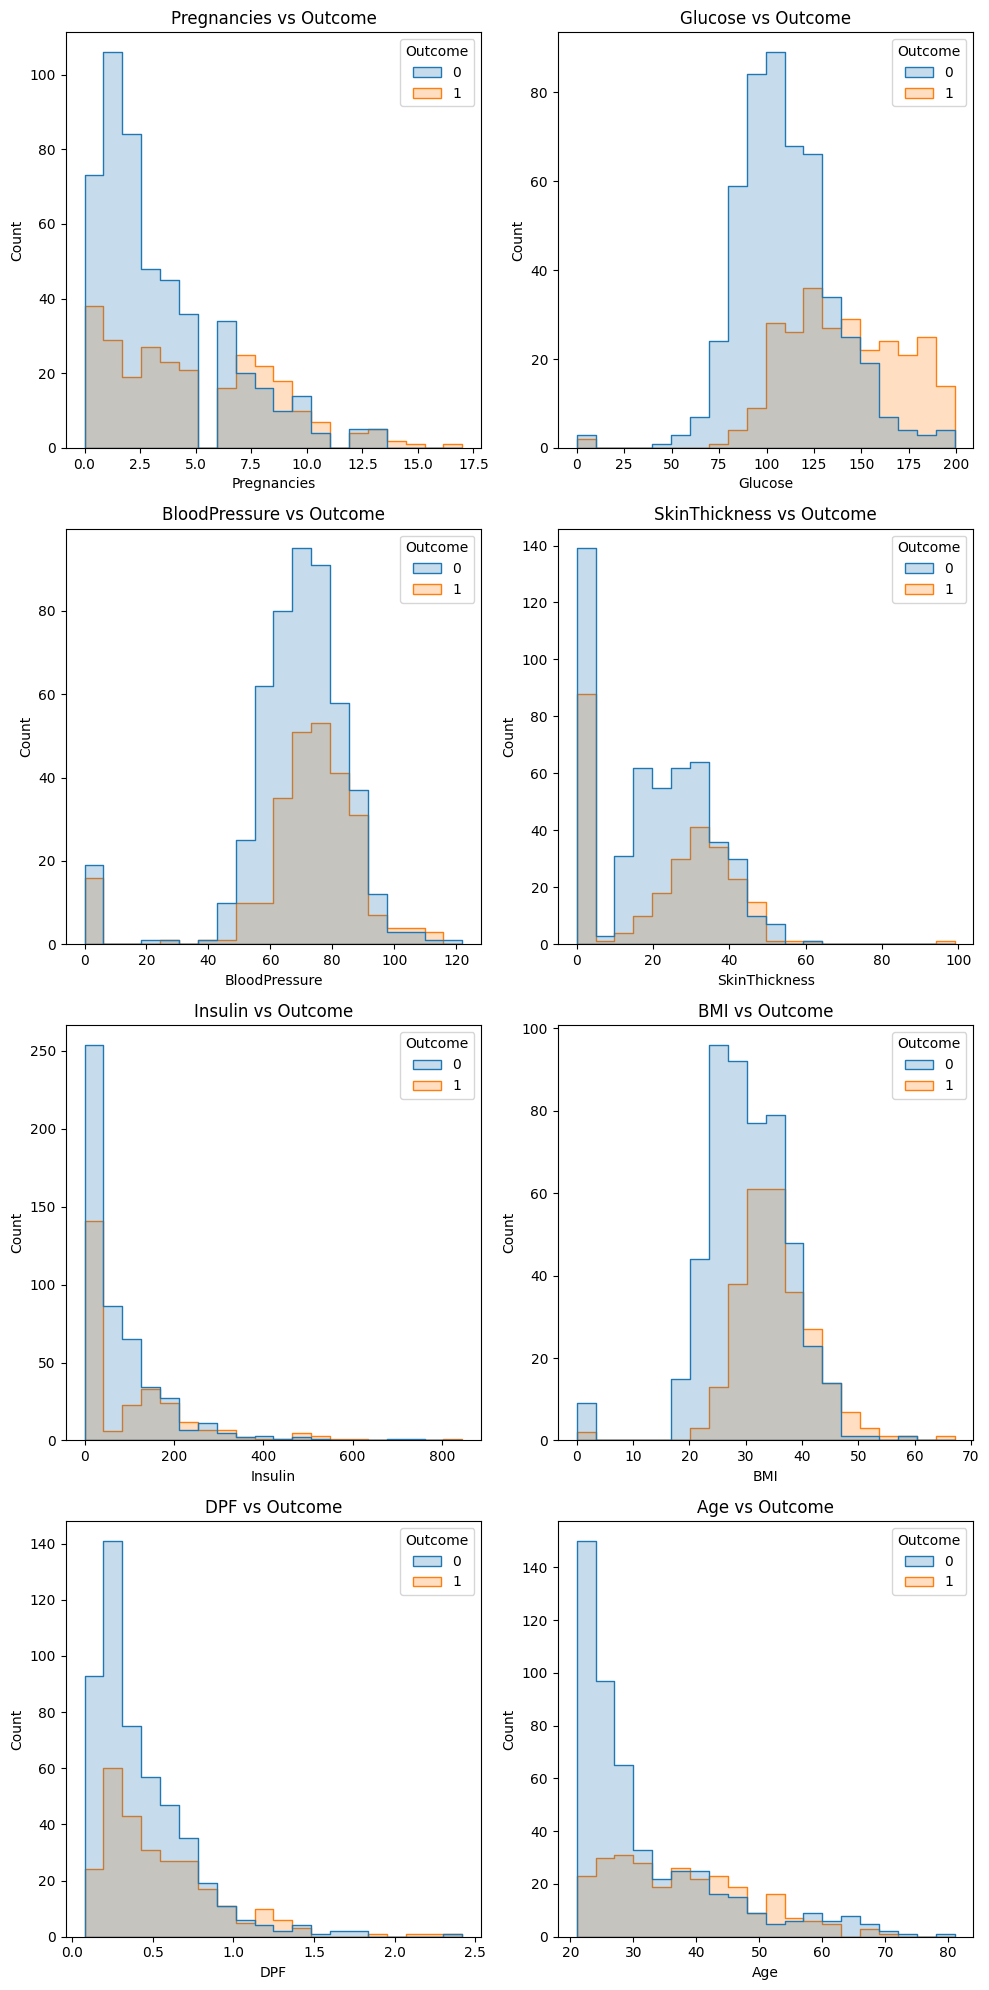

In [29]:
plt.figure(figsize=(10, 20))

for i, col in enumerate(cols, 1):
    plt.subplot(4, 2, i)
    sns.histplot(data=df_dataset, x=col, hue="Outcome", bins=20, kde=False, element="step")
    plt.title(f"{col} vs Outcome")

plt.tight_layout()
plt.show()

**Nhận xét:**
+ Số lần mang thai trung bình ở nhóm Outcome = 1 (mắc tiểu đường) dường như cao hơn.
+ Những người mắc tiểu đường thường có chỉ số **glucose** cao hơn, trong khi những người bình thường thì **glucose** trong khoảng **90-100**.
+ Xu hướng của **BloodPressure** trông giống nhau ở cả nhóm mắc tiểu đường và không mắc tiểu đường.
+ **SkinThickness** trung bình của những người mắc tiểu đường có vẻ cao hơn một chút so với những người không mắc tiểu đường.
+ Mức **insulin** gần như giống nhau, chỉ khác là khoảng giá trị **insulin** của nhóm không mắc tiểu đường hẹp hơn.
+ Chỉ số **BMI** tương tự với SkinThickness.
+ Giá trị max và average của **DFF** của nhóm Outcome = 1 cao hơn.
+ Nhóm người không mắc bệnh nằm trong độ tuổi **20**, còn những người mắc bệnh thì trải đều **20-40** và cũng có nhiều trường hợp **>50**.

#### (2) Hiển thị nhiều tính chất (Multivariate Plots)

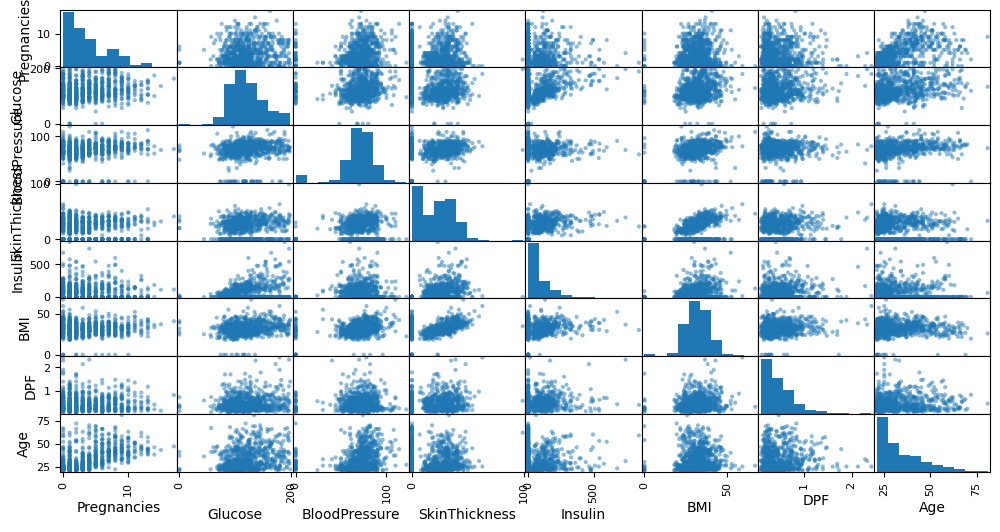

In [30]:
pd.plotting.scatter_matrix(df_dataset[cols], figsize=(12,6));